# Location patterns 2 - extreme recombination rates
This notebook explores ...

In [26]:
# Initiate notebook with packages
# -------------------------------

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import rpy2.rinterface
%load_ext rpy2.ipython
import random 
import scipy.stats
# import math
from plotnine import  ggplot, data, geom_histogram, aes, geom_bar, geom_rect,geom_hline, scale_x_discrete,  theme, element_text, ggtitle, xlab, ylab, facet_wrap, geom_point, stat_smooth, annotate, geom_text, geom_boxplot, geom_col, facet_grid
import warnings
warnings.filterwarnings('ignore')


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:

# Set working directory
# ------------------------------
os.chdir("../../")

In [12]:
# Set figure counter for text
# ------------------------------
figcounter = 0

# Load chromosome data
# -------------------------------

gap = pd.read_csv('data/raw/gap.txt', sep = '\t', header = None )
gap.set_axis(['bin','chrom','chromStart','chromEnd','ix','n','size','type','bridge'], axis = 1, inplace = True)

band = pd.read_csv('data/raw/cytoBand.txt', sep = '\t', header = None )
band.set_axis(['chrom','chromStart','chromEnd','name','gieStain'], axis = 1, inplace = True)

sizes = pd.read_csv('data/raw/chrSizes.txt', sep = '\t')

genSize = pd.read_csv("data/use/BhererGeneticDistance.txt", sep = "\t", header = None)
genSize.set_axis(["Chromosome", "Position", "Rate", "cM"] ,axis = 1, inplace = True)

recRate = pd.read_csv("data/use/BhererAllChroms.txt", sep = "\t", header = None)
recRate.set_axis(["Chromosome", "Position", "Rate", "cM"] ,axis = 1, inplace = True)

# Load repeat data
# -------------------------------

segDups = pd.read_csv('data/raw/genomicSuperDups.txt', sep = '\t'  )

# Load and clean inversion data
# -------------------------------

inv = pd.read_csv('data/use/InversionsAnnotation_133Inv_20211117.csv', sep = '\t', skiprows=1, skip_blank_lines=True)
inv = inv.iloc[:,[0,1,2,11,12,13,14]]
inv = inv.dropna()

Ori_fixed =  inv["Origin"].replace(regex = ["NAHR.*"], value = "NAHR" )
Ori_fixed = Ori_fixed.replace(regex = ["NH.*"], value = "NH" )
inv["OriginFixed"] = Ori_fixed
inv["CenterPos"] = inv["BP1_1.1"] + ((inv["BP2_2.1"]- inv["BP1_1.1"] +1 )/2) -1 # now it is 0-based


print(f"""We will be analyzing {inv.shape[0]} inversions, {Ori_fixed[Ori_fixed == "NAHR"].count()} NAHR and {Ori_fixed[Ori_fixed == "NH"].count()} NH.""")


We will be analyzing 133 inversions, 54 NAHR and 79 NH.


# Extreme recombination rates - calculation


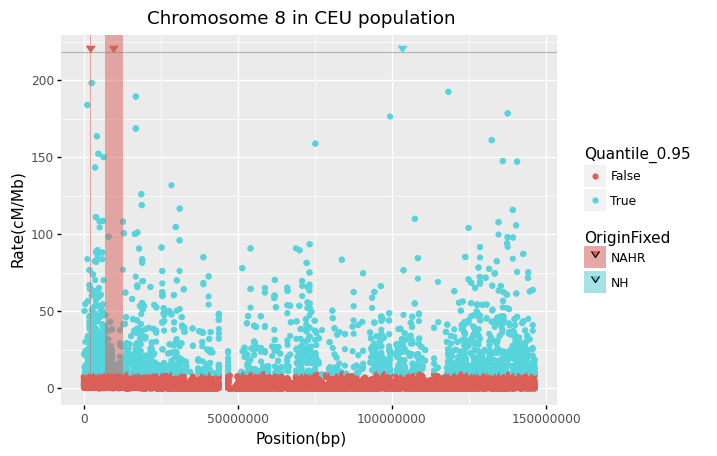

<ggplot: (8792008350395)>

In [81]:
# Load recombination files list
# os.listdir("data/raw/hg19/KHV/")
chrom = "8"
pop="CEU"
sig = 0.95
namesig = "Quantile_"+str(sig)

genSize = pd.read_csv("data/raw/hg19/"+pop+"/"+pop+"_recombination_map_hapmap_format_hg19_chr_"+chrom+".txt", sep = "\t")

# genSize["Rate(cM/Mb)"].describe()

threshold = np.quantile(genSize["Rate(cM/Mb)"], sig)

genSize[namesig] = genSize["Rate(cM/Mb)"] > threshold

(
    ggplot()+
    geom_point(genSize, aes(x = "Position(bp)", y = "Rate(cM/Mb)", color = namesig))+
    geom_rect( inv[inv.Chr == "chr"+chrom], aes(xmax = "BP1_1.1", xmin = "BP2_2.1", ymax = np.inf , ymin=0,  fill = "OriginFixed"), alpha = 0.5)+
    geom_hline(yintercept =max(genSize["Rate(cM/Mb)"])+20, color = "gray", alpha = 0.5)+
    geom_point( inv[inv.Chr == "chr"+chrom], aes(x = "CenterPos", y = max(genSize["Rate(cM/Mb)"]+20), fill = "OriginFixed"),shape = 7 , size = 3)+
    ggtitle("Chromosome "+chrom+" in "+pop+" population")
)

In [78]:
# Additional files for GAT
# Question: The question we ask is whether within the genome (== WORKSPACE), 
# (SRF binding events == INVERSIONS == SEGMENTS) 
# are in regions of (open chromatin == HIGH REC == ANNOTATIONS) as identified by (DNAse I hypersensitive sites == ERRs).
# WORKSPACE
sizes["start"] = 0
workspace = sizes[["Chromosome", "start", "Totallength(bp)"]]
workspace

workspace.to_csv("tmp/OverlapTest/contigs.bed", sep = "\t", header=False, index = False)

# SEGMENTS (inversions)
segments = inv[["Chr", "BP1_1.1", "BP2_2.1", "INV"]]
segments_NH = inv[inv["OriginFixed"] == "NH"][["Chr", "BP1_1.1", "BP2_2.1", "INV"]]
segments_NAHR = inv[inv["OriginFixed"] == "NAHR"][["Chr", "BP1_1.1", "BP2_2.1", "INV"]]

segments.to_csv("tmp/OverlapTest/segments.bed", sep = "\t", header=False, index = False)
segments_NH.to_csv("tmp/OverlapTest/segments_NH.bed", sep = "\t", header=False, index = False)
segments_NAHR.to_csv("tmp/OverlapTest/segments_NAHR.bed", sep = "\t", header=False, index = False)

# ANNOTATIONS (ERRs)
sig = 0.95
namesig = "Quantile_"+str(sig)

genSize = pd.read_csv("tmp/OverlapTest/CEU_recombination_map_hg19_allChr.bed", sep = "\t", header = None, index_col=False)
genSize.set_axis(["Chrom", "start", "end", "recrate_base_gen"], axis = 1, inplace= True)

threshold = np.quantile(genSize["recrate_base_gen"], sig)

genSize[namesig] = genSize["recrate_base_gen"] > threshold

annotations = genSize[genSize["Quantile_0.95"]][["Chrom", "start", "end", "recrate_base_gen"]]
annotations.to_csv("tmp/OverlapTest/annotations.bed", sep = "\t", header=False, index = False)


# gat-run.py \
#    --segments=segments.bed \
#    --annotations=annotations.bed \
#    --workspace=contigs.bed \
#    --ignore-segment-tracks --num-samples=1000 --log=gat.log > gat.tsv 



'\ngat-run.py\n   --segments=segments.bed\n   --annotations=annotations.bed\n   --workspace=contigs.bed \n   --ignore-segment-tracks --num-samples=1000 --log=gat.log > gat.tsv\n\n'

# Old examples for reference


## Differences in distribution between chromosomes

Smaller chromosomes have higher recombination rates than big ones to make sure that there are enough chiasmata to correctly seggregate. Probably because of this difference, small autosomes have more NAHR inversions per Mb than big autosomes, while NH inversions are randomly distributed (Figures 3 & 4). As it is already known, the excess of repeats in chromosome X causes a significant enrichment of NAHR inversions. There are no differences in inversion sizes between chromosome types (Figure 5).  

In [ ]:
# Make table for per-chromosome analyses
#----------------------------------------

# Set chromosome names list
a = np.char.array(list(map(str,range(1,23)))+["X", "Y"])
b = np.char.array(["chr"] * 24)
chrNames = b+a 
chrTypes = ( ["BigAutosome"] * 12 + ["SmallAutosome"] * 10 + ["SexChr"] * 2)

byChrInfo = DataFrame({"Chromosome" : chrNames, "chromType" : chrTypes})

# Count inversions and inversion types
## InvCounts
byChrInfo = byChrInfo.merge(Series(inv.Chr.value_counts(), name = "invCounts"), how = "left", left_on= "Chromosome", right_index=True )
## NAHRCounts
byChrInfo = byChrInfo.merge( Series(inv[inv.OriginFixed == "NAHR"].Chr.value_counts(), name = "NAHRCounts"),  how = "left", left_on= "Chromosome", right_index=True )
## NHCounts
byChrInfo = byChrInfo.merge( Series(inv[inv.OriginFixed == "NH"].Chr.value_counts(), name = "NHCounts"), how = "left", left_on= "Chromosome", right_index=True )

# Count repeats and intrachromosomal repeats
## All repeats
byChrInfo = byChrInfo.merge( Series(segDups.chrom.value_counts() + segDups.otherChrom.value_counts(), name = "allRepCounts"), how = "left", left_on= "Chromosome", right_index=True )
## Intrachromosomal repeats, Multiplied because each row represents 2 incidences
byChrInfo = byChrInfo.merge( Series(segDups[segDups.chrom == segDups.otherChrom].chrom.value_counts() * 2 , name = "intraRepCounts"), how = "left", left_on= "Chromosome", right_index=True )

# Add chromosome size
byChrInfo = byChrInfo.merge(sizes[["Chromosome", "Totallength(bp)"]], how = "left" )
byChrInfo = byChrInfo.merge(genSize[["Chromosome", "cM"]], how = "left" )
# Clean empty falues
byChrInfo.fillna(0, inplace = True)

# Calculate densities
byChrInfo["invDensity"] = byChrInfo.invCounts / byChrInfo["Totallength(bp)"]
byChrInfo["NAHRDensity"] = byChrInfo.NAHRCounts / byChrInfo["Totallength(bp)"]
byChrInfo["NHDensity"] = byChrInfo.NHCounts / byChrInfo["Totallength(bp)"]
byChrInfo["allRepDensity"] = byChrInfo.allRepCounts / byChrInfo["Totallength(bp)"]
byChrInfo["intraRepDensity"] = byChrInfo.intraRepCounts / byChrInfo["Totallength(bp)"]
byChrInfo["Rate(cM/Mb)"] = byChrInfo.cM / (byChrInfo["Totallength(bp)"]/1000000)

### Autosomes - variable exploration 

In [ ]:
# Filter table to have autosomes only
#--------------------------------------

sexChromosomes = byChrInfo[byChrInfo.Chromosome.isin(["chrX", "chrY"])]

Autosomes = byChrInfo[~ byChrInfo.Chromosome.isin(["chrX", "chrY"])]


In [ ]:
%%R -i Autosomes -h 3508 -w 2480 -r 300

library("corrplot")

rownames(Autosomes) <- Autosomes$Chromosome

toPlot <- Autosomes[,c(3:ncol(Autosomes))]

toPlotCor = cor(as.matrix(toPlot))
testRes = cor.mtest(toPlot, conf.level = 0.95)

corrplot(toPlotCor, p.mat = testRes$p, sig.level = c(0.001, 0.01, 0.05), pch.cex = 0.9, insig = 'label_sig', type = "lower", method = "square", col = COL2('PRGn'), diag = FALSE)

In [ ]:
%%R -i Autosomes -h 3508 -w 2480 -r 300

library("corrplot")

rownames(Autosomes) <- Autosomes$Chromosome

toPlot <- Autosomes[which(Autosomes$chromType == "BigAutosome" ),c(3:ncol(Autosomes))]

toPlotCor = cor(as.matrix(toPlot))
testRes = cor.mtest(toPlot, conf.level = 0.95)

corrplot(toPlotCor, p.mat = testRes$p, sig.level = c(0.001, 0.01, 0.05), pch.cex = 0.9, insig = 'label_sig', type = "lower", method = "square",col = COL2('PRGn'), diag = FALSE)

In [ ]:
%%R -i Autosomes -h 3508 -w 2480 -r 300

library("corrplot")

rownames(Autosomes) <- Autosomes$Chromosome

toPlot <- Autosomes[which(Autosomes$chromType == "SmallAutosome" ),c(3:ncol(Autosomes))]

toPlotCor = cor(as.matrix(toPlot))
testRes = cor.mtest(toPlot, conf.level = 0.95)

corrplot(toPlotCor, p.mat = testRes$p, sig.level = c(0.001, 0.01, 0.05), pch.cex = 0.9, insig = 'label_sig', type = "lower", method = "square",col = COL2('PRGn'), diag = FALSE)

In [ ]:
%%R -i Autosomes -h 3508 -w 2480 -r 300
# 3508 x 2480 r 300
library("PerformanceAnalytics")

rownames(Autosomes) <- Autosomes$Chromosome

toPlot <- Autosomes[,c(3:ncol(Autosomes))]

chart.Correlation(toPlot, histogram=TRUE, pch = "+")


In [ ]:
%%R -i Autosomes -h 3508 -w 2480 -r 300
# 3508 x 2480 r 300
library("PerformanceAnalytics")
rownames(Autosomes) <- Autosomes$Chromosome

toPlot <- Autosomes[which(Autosomes$chromType == "BigAutosome" ),c(3:ncol(Autosomes))]

chart.Correlation(toPlot, histogram=TRUE)

In [ ]:
%%R -i Autosomes -h 3508 -w 2480 -r 300
# 3508 x 2480 r 300
library("PerformanceAnalytics")
rownames(Autosomes) <- Autosomes$Chromosome

toPlot <- Autosomes[which(Autosomes$chromType == "SmallAutosome" ),c(3:ncol(Autosomes))]

chart.Correlation(toPlot, histogram=TRUE)

In [ ]:
# Distribution of inversions by chromosome overview - a plot
# -------------------------------

# Make barplot values 
hist = DataFrame(inv.Chr.value_counts())

# Set chromosome names list
a = np.char.array(list(map(str,range(1,23)))+["X", "Y"])
b = np.char.array(["chr"] * 24)
chrNames = b+a 

# Make plot 
(
    ggplot(hist)+
        geom_bar(aes(x = hist.index, y = "Chr"), stat="identity")+
        scale_x_discrete(limits = chrNames)+
        theme( axis_text_x = element_text(angle = 45, vjust = 1, hjust=1))+
        ylab("Inversion count")+
        ggtitle("Number of inversions on each chromosome")

)



In [ ]:
figcounter+=1
print(f"Figure {figcounter}: Number of inversions for each chromosome in the dataset")


In [ ]:
# Distribution of inversions by chromosome size
# -------------------------------

# Take chromosome sizes
chromSize = gap[(gap.type == "telomere") & (gap.chromStart!=0)][["chrom", "chromEnd"]]

# Join with inversion count
prop = pd.merge(chromSize, hist, left_on="chrom", right_index=True)

# Plot correlation
plotSubset = prop[~prop["chrom"].isin(["chrX", "chrY"])]


In [ ]:
%%R -i plotSubset -r 100

library(ggpubr)

ggscatter(plotSubset, x = "chromEnd", y = "Chr",
          add = "reg.line",                                 
          conf.int = TRUE,                                  
          add.params = list(color = "black",
                            fill = "gray60"),
          ggtheme = theme_gray() 
        )+
  stat_cor(method = "pearson")+
  ggtitle("Correlation between size and inversions ")+
  ylab("Inversion count")+xlab("Autosome size")  


In [ ]:
figcounter+=1
print(f"Figure {figcounter}: There is a moderate, significant positive correlation between autosome size and inversion count when all inversions and autosomes are considered.")


In [ ]:
# Distribution of inversions by chromosome size, grouped - BOXPLOT
# -------------------------------

# Set chromosome types list
chrTypes = ( ["BigAutosome"] * 12 + ["SmallAutosome"] * 10 + ["SexChr"] * 2)

# Join chromosome types with chromosome names
chrClassified = DataFrame({"chrNames":chrNames, "chrTypes": chrTypes})

# Join chromosome types to inversion info
inv = pd.merge(inv, chrClassified,  left_on = "Chr", right_on = "chrNames" )

# Make per-chromosome inversion counts
inv_grouped = inv.groupby(["OriginFixed","Chr" ])
IDs_grouped = inv_grouped["INV"]

IDs_counted = IDs_grouped.size().unstack().melt( ignore_index= False )
IDs_counted["OriginFixed"] = IDs_counted.index

# Add chromosome size
proportions = pd.merge(IDs_counted, chromSize, left_on = "Chr", right_on="chrom")
proportions["value"] = proportions["value"].replace(np.NaN, 0)
proportions["InvsPerMb"] = proportions["value"] / (proportions["chromEnd"]/1000000)


# Join inversion counts with chrTypes
ICounts_CTypes = pd.merge(proportions, chrClassified, left_on = "Chr", right_on = "chrNames" )

# Make boxplot
(
    ggplot(ICounts_CTypes)+
    geom_boxplot(aes(x = "chrTypes", fill = "OriginFixed", y = "InvsPerMb"))+
    ggtitle("Inversions/Mb in different chromosome types")+
    ylab("Inversion/Mb")+xlab("Chromosome type") 

)



# Join inversion counts with chrTypes
ICounts_CTypes = pd.merge(proportions, chrClassified, left_on = "Chr", right_on = "chrNames" )

# Make boxplot
(
    ggplot(ICounts_CTypes)+
    geom_boxplot(aes(x = "chrTypes", fill = "OriginFixed", y = "InvsPerMb"))+
    ggtitle("Inversions/Mb in different chromosome types")+
    ylab("Inversion/Mb")+xlab("Chromosome type") 

)



In [ ]:
NAHR_invcount = ICounts_CTypes[ICounts_CTypes.OriginFixed == "NAHR"]["value"].sum()
NH_invcount = ICounts_CTypes[ICounts_CTypes.OriginFixed == "NH"]["value"].sum()
proportion = NH_invcount / NAHR_invcount


compcounts = ICounts_CTypes[ICounts_CTypes.OriginFixed == "NH"][["value", "chrom", "chrTypes"]].merge(ICounts_CTypes[ICounts_CTypes.OriginFixed == "NAHR"][["value", "chrom"]], on = "chrom", suffixes = ("_NH", "_NAHR"))
compcounts["proportion"] = compcounts.value_NH / compcounts.value_NAHR

compcounts = compcounts.replace([np.inf, -np.inf], np.nan)
smallRatio = round(compcounts[(compcounts.chrTypes == "SmallAutosome")]["proportion"].mean(),(3) )
bigRatio = round(compcounts[(compcounts.chrTypes == "BigAutosome")]["proportion"].mean(), (3))
sexRatio = round(compcounts[(compcounts.chrTypes == "SexChr")]["proportion"].mean(), 3)

figcounter+=1
print(f"""Figure {figcounter}: Different chromosome types have different distribution of inversion origins. Big Autosomes are chromosomes 1-12, Small Autosomes are chromosomes 13-22, inversion counts are corrected by chromosome size. The general NAHR:NH ratio is 1:{proportion.round(2)}, while in chromosome X is 1:{sexRatio * 2}, in Big chromosomes the mean ratio is 1:{bigRatio} and in Small chromosomes the mean ratio is 1:{smallRatio}.""") 


In [ ]:
# Distribution of inversions by chromosome size, grouped - CORRELATION
# -------------------------------

IC_CT_auto = ICounts_CTypes[ ~ ICounts_CTypes["chrNames"].isin(["chrX", "chY"])]



In [ ]:
%%R -i IC_CT_auto -r 100

library(ggpubr)

ggscatter(IC_CT_auto, x = "chromEnd", y = "value",
          add = "reg.line",                                 
          conf.int = TRUE,                                  
          add.params = list(color = "black",
                            fill = "gray60"),
          ggtheme = theme_gray() 
        )+
  stat_cor(method = "pearson")+
  facet_grid(OriginFixed ~ .)+ 
  ggtitle("Correlation between size and inversions")+
  ylab("Inversion count")+xlab("Autosome size")


In [ ]:
figcounter+=1
print(f"Figure {figcounter}: The correlation between Autosome size and inversion count is affected by the differential distributions observed in Figure {figcounter-1}. NH inversion counts show a strong, significant positive correlation with chromosome size, while no such correlation is observed for NAHR inversions because of their excess in Small chromosomes and depleat Big chromosomes." )

In [ ]:
# SEGMENTAL DUPLICATIONS
# -----------------------------

# Make per-chromosome repeat counts
# Filter intrachromosomal segDups
sD_intra = segDups[segDups.chrom == segDups.otherChrom]
sD_grouped = sD_intra.groupby(["chrom" ])
# Count
sD_groupedIDs = sD_grouped["name"]
sD_counted = DataFrame(sD_groupedIDs.size())

# Add chromosome size
sD_prop = pd.merge(sD_counted, chromSize, left_on = "chrom", right_on="chrom")
sD_prop["RepsPerMb"] = sD_prop["name"] / (sD_prop["chromEnd"]/1000000)

# Merge with inversion counts
repInvs =pd.merge(ICounts_CTypes, sD_prop, left_on = "Chr", right_on="chrom", how = "left")

# DELETE THIS TO INCLUDE SEXUAL CHROMOSOMES
repInvs = repInvs[  ~ repInvs.Chr.isin(["chrX", "chrY"]) ]



In [ ]:
%%R -i repInvs -r 100

library(ggpubr)

ggscatter(repInvs, x = "name", y = "value",
          add = "reg.line",                                 
          conf.int = TRUE,                                  
          add.params = list(color = "black",
                            fill = "gray60"),
          ggtheme = theme_gray() 
        )+
  stat_cor(method = "pearson")+
  facet_grid(OriginFixed ~ .)+ 
  ggtitle("Correlation between segdups and inversion count \n(autosomes)")+
  ylab("Inversion count")+xlab("Intrachromosomal Segmental Duplications count") 


In [ ]:
inv["InvSize"] = inv["BP2_2.1"] - inv["BP1_1.1"] +1
inv["logInvSize"] = np.log10(inv["InvSize"])
(
    ggplot(inv)+
    geom_boxplot(aes(x = "chrTypes", y = "logInvSize"))+
    facet_grid(". ~ OriginFixed")+
    ggtitle("Distribution of inversions sizes")+
    xlab("Chromosome types")+ylab("log10(Inversion sizes)")  

)

In [ ]:
figcounter+=1
print(f"Figure {figcounter}: Inversion sizes seem to be evenly distributed across chromosome types. " )

## Differences in distribution within chromosomes

Similarly, the known, lage-scale recombination patterns within chromosome arms affect inversion incidence. We don't have much power in small autosomes to identify location patterns, but in big autosomes there is an important proportion of NAHR inversions occuring near telomeres, where recombination rates are higher. On the other hand, NH inversions tend to concentrate around the center of the chromosome arm (Figures 6,7,8). NH inversions distribution is similar to a simulated distribution that exemplifies how the probability of having two breaks at a suitable distance to generate an inversion is higher around the center of the arm than near centromeres and telomeres (Figure 9). 


In [ ]:
# Calculate chromosome arms
# ---------------------------------------

# Select centromeres as p arm End
center = band[(band['gieStain'] == 'acen') & (band['name'].str.startswith('p') )]
center = center[['chrom', 'chromEnd']]

# Select chromosome end as q arm End
groupedBand = band['chromEnd'].groupby(band['chrom'])
end = DataFrame(groupedBand.max() )
end.reset_index(level=['chrom'], inplace = True)

# Set q arm Start
end = pd.merge(end, center, on = 'chrom')
end.set_axis(['chrom','chromEnd','chromStart'], axis = 1, inplace = True)

# Set p arm Start
center['chromStart'] = 0

# Set p and q flags
center['chromArm']='p'
end['chromArm']='q'

# Join data
chromArms = pd.concat([center, end])

# Armsize
chromArms["ArmSize"] = chromArms["chromEnd"] - chromArms["chromStart"] # no need to sum-rest, 0 based



# Calculate % of arm in which the center of the inversion is placed
# ---------------------------------------

# Make center of inversion
inv["Center_pos"] = inv["BP1_1.1"] + ((inv["BP2_2.1"]- inv["BP1_1.1"] +1 )/2) -1 # now it is 0-based

# For each inversion, calculate chromosome arm
inv["chromArm"] = [ chromArms[(chromArms.chromStart < row.Center_pos )& (chromArms.chromEnd > row.Center_pos) & (row.Chr == chromArms.chrom)]["chromArm"].iloc[0] for index, row in inv.iterrows() ]

# Calculate % of arm where inversion is, 0 = start, 100 = end
percList = []

for index, row in inv.iterrows():
    myrow = chromArms[(chromArms.chrom == row.Chr) & (chromArms.chromArm == row.chromArm)].iloc[0]
    value = ((row.Center_pos - myrow.chromStart ) / myrow.ArmSize ) * 100
    percList.append(value)

inv["armPerc"] = percList

# Change percentages to be 0 = centromere, 100 = telomere
mask = (inv.chromArm == "p")
inv_valid = inv[mask]

inv["armPerc_Telocen"] = inv["armPerc"]
inv.loc[mask, 'armPerc_Telocen'] = 100 - inv_valid["armPerc"]

In [ ]:
(
    ggplot(inv)+
    geom_histogram(aes(x = "armPerc_Telocen"), bins=10)+
    facet_grid("chrTypes ~ .", scales = "free")+
    ggtitle("Distribution of inversions along chromosome arms")+
    xlab("Chromosome arm positional percentage (Centromere to Telomere)")+ylab("Inversion counts")  
)

In [ ]:
figcounter+=1
print(f"Figure {figcounter}: Distribution of inversion counts along chromosome arms, where 0 is the centromere and 100 is the telomere. Inversions seem to be located preferently around centromeres when not taking into account inversion origin, although in Sex chromosomes an Small Autosomes the first bin, most proximal to the centromere, is empty." )

In [ ]:
(
    ggplot(inv)+
    geom_histogram(aes(x = "armPerc_Telocen"), bins=10)+
    facet_grid("OriginFixed ~ .", scales = "free")+
    ggtitle("Distribution of inversions along chromosome arms")+
    xlab("Chromosome arm positional percentage (Centromere to Telomere)")+ylab("Inversion counts")  
)

In [ ]:
figcounter+=1
print(f"Figure {figcounter}: Distribution of inversion counts along chromosome arms, where 0 is the centromere and 100 is the telomere. NAHR inversions are preferently located near centromeres and telomeres, while NH inversions seem to be more dsitributed along the chromosome arm. " )

In [ ]:
(
    ggplot(inv)+
    geom_histogram(aes(x = "armPerc_Telocen"), bins=5)+
    facet_wrap("~ chrTypes + OriginFixed", scales = "free")+
    ggtitle("Distribution of inversions along chromosome arms")+
    xlab("Chromosome arm positional percentage (Centromere to Telomere)")+ylab("Inversion counts")  
)

In [ ]:
figcounter+=1
print(f"Figure {figcounter}: Distribution of inversion counts along chromosome arms, where 0 is the centromere and 100 is the telomere. When looking at all the categories, we loose definition, especially for small chromosomes. The most evident patterns can be observed in Big chromosomes: NH inversions concentrate in the middle of the chromosome arm while most NAHR generate near telomeres." )

In [ ]:
chrom_start = 0
chrom_end = 125000000 # chromosome 1 p arm size
inv_size = inv[inv.OriginFixed == "NH"]["InvSize"] /2
multiplicator = 10

random.seed(1)
choices = np.array([random.randint(chrom_start, chrom_end) for _ in range(inv_size.count() * multiplicator) ])

choices_start = choices - inv_size.repeat(multiplicator) /2
choices_end = choices + inv_size.repeat(multiplicator) /2

accepted = choices[(choices_start >= 0) & (choices_end <= chrom_end)]

(
    ggplot(DataFrame(accepted))+
    geom_histogram(aes(x = "accepted"), bins = 5)+
    ggtitle("Distribution of randomly generated fragments")+
    xlab("Chromosome arm positional percentage (Centromere to Telomere)\n Simulated chr1.p")+ylab("Simulated inversion counts")  
)

In [ ]:
figcounter+=1
print(f"Figure {figcounter}: Simulated distribution of inversions along a chromosome arm. One random point in the map was assigned to each of the {inv_size.count()} NH inversions, and then the corresponding breakpoints calculated according to inversion size. If inversion breakpoints fell outside the map limits, the inversion was discarded. This process was repeated {multiplicator} times." )


## By chromosome regions 

In [ ]:
# Make fragments
# -----------------------------------------

fragCount = 5

allChromRegions = DataFrame()
for ch in recRate.Chromosome.unique(): 
    minirate = recRate[(recRate.Chromosome == ch) & (recRate.Position >0) ]

    win = round(max(minirate.Position)/fragCount)
    positions = range(0,max(minirate.Position), win) 
    means = [ minirate[(minirate.Position >= r) & (minirate.Position < r+win)].Rate.mean() for r in positions ]

    averages = DataFrame({"Positions" : positions, "MeanRates" : means, "Positions_end": range(win, max(minirate.Position) + win, win), "Chromosome":ch})
    allChromRegions = allChromRegions.append(averages)

    allChromRegions.Chromosome = pd.Categorical(allChromRegions.Chromosome, categories = chrNames)
# Test regions
# ----------------------------------------

(ggplot(allChromRegions)+
    geom_rect(aes(xmin = "Positions", xmax = "Positions_end",   ymax = "MeanRates", ymin = 0))+
    facet_wrap("Chromosome", scales = "free")
)

In [ ]:
# Calculate the same as before for each region
# -----------------------------------------------------
# Make table for per-chromosome analyses
#----------------------------------------

# Set chromosome names list
# a = np.char.array(list(map(str,range(1,23)))+["X", "Y"])
# b = np.char.array(["chr"] * 24)
# chrNames = b+a 
# chrTypes = ( ["BigAutosome"] * 12 + ["SmallAutosome"] * 10 + ["SexChr"] * 2)

# chromNames = DataFrame({"Chromosome" : chrNames, "chromType" : chrTypes})
# allChromRegions = allChromRegions.merge(chromNames)


In [ ]:
# Now calculate the incidences for each segment
# ------------------------------------------------

# Number of invs
inv["CenterPos"] = inv["BP1_1.1"] + ((inv["BP2_2.1"]- inv["BP1_1.1"] +1 )/2) -1 # now it is 0-based
inv["CenterBP1"] = inv["BP1_1.1"] + ((inv["BP1_2.1"]- inv["BP1_1.1"] +1 )/2) -1 # now it is 0-based
inv["CenterBP2"] = inv["BP2_1.1"] + ((inv["BP2_2.1"]- inv["BP2_1.1"] +1 )/2) -1 # now it is 0-based

allChromRegions["invCenters"] = [len(inv[(inv.Chr == row["Chromosome"]) & (inv.CenterPos >= row["Positions"]) & (inv.CenterPos < row["Positions_end"])].index) for index, row in allChromRegions.iterrows()]

allChromRegions["invBreakpoints"] = [
    len(inv[(inv.Chr == row["Chromosome"]) & (inv.CenterBP1 >= row["Positions"]) & (inv.CenterBP1 < row["Positions_end"])].index) +
    len(inv[(inv.Chr == row["Chromosome"]) & (inv.CenterBP2 >= row["Positions"]) & (inv.CenterBP2 < row["Positions_end"])].index) 
    for index, row in allChromRegions.iterrows()
    ]

# Number of invs of each type
## NH
allChromRegions["NHCenters"] = [
    len(inv[(inv.Chr == row["Chromosome"]) & (inv.CenterPos >= row["Positions"]) & (inv.CenterPos < row["Positions_end"]) & (inv.OriginFixed == "NH" )].index) 
    for index, row in allChromRegions.iterrows()
    ]

allChromRegions["NHBreakpoints"] = [
    len(inv[(inv.Chr == row["Chromosome"]) & (inv.CenterBP1 >= row["Positions"]) & (inv.CenterBP1 < row["Positions_end"]) & (inv.OriginFixed == "NH" )].index) +
    len(inv[(inv.Chr == row["Chromosome"]) & (inv.CenterBP2 >= row["Positions"]) & (inv.CenterBP2 < row["Positions_end"]) & (inv.OriginFixed == "NH" )].index) 
    for index, row in allChromRegions.iterrows()
    ]

## NAHR
allChromRegions["NAHRCenters"] = [
    len(inv[(inv.Chr == row["Chromosome"]) & (inv.CenterPos >= row["Positions"]) & (inv.CenterPos < row["Positions_end"]) & (inv.OriginFixed == "NAHR" )].index) 
    for index, row in allChromRegions.iterrows()
    ]

allChromRegions["NAHRBreakpoints"] = [
    len(inv[(inv.Chr == row["Chromosome"]) & (inv.CenterBP1 >= row["Positions"]) & (inv.CenterBP1 < row["Positions_end"]) & (inv.OriginFixed == "NAHR" )].index) +
    len(inv[(inv.Chr == row["Chromosome"]) & (inv.CenterBP2 >= row["Positions"]) & (inv.CenterBP2 < row["Positions_end"]) & (inv.OriginFixed == "NAHR" )].index) 
    for index, row in allChromRegions.iterrows()
    ]

# Count repeats and intrachromosomal repeats
segDups.chromCenter = segDups["chromStart"] + ((segDups["chromEnd"]- segDups["chromStart"] +1 )/2) -1
segDups.otherCenter = segDups["otherStart"] + ((segDups["otherEnd"]- segDups["otherStart"] +1 )/2) -1
## All repeats
allChromRegions["allRepCounts"] =[
    len(segDups[(segDups.chrom == row["Chromosome"]) & (segDups.chromCenter >= row["Positions"]) & (segDups.chromCenter < row["Positions_end"])].index) + 
    len(segDups[(segDups.otherChrom == row["Chromosome"]) & (segDups.otherCenter >= row["Positions"]) & (segDups.otherCenter < row["Positions_end"])].index)
    for index, row in allChromRegions.iterrows()
    ]
## Intrachromosomal repeats, each copy counted different because they can be in different regions 
allChromRegions["intraRepCounts"] = [
    len(segDups[(segDups.chrom == segDups.otherChrom) & (segDups.chrom == row["Chromosome"]) & (segDups.chromCenter >= row["Positions"]) & (segDups.chromCenter < row["Positions_end"])].index) + 
    len(segDups[(segDups.chrom == segDups.otherChrom) & (segDups.otherChrom == row["Chromosome"]) & (segDups.otherCenter >= row["Positions"]) & (segDups.otherCenter < row["Positions_end"])].index)
    for index, row in allChromRegions.iterrows()
    ] 

# Add segment size
allChromRegions["Length(bp)"] = allChromRegions.Positions_end - allChromRegions.Positions

# In this dataset we only have autosomes

In [ ]:
%%R -i allChromRegions -h 3508 -w 2480 -r 300

library("corrplot")

rownames(allChromRegions) <- paste0(allChromRegions$Chromosome, allChromRegions$Positions)

toPlot <- allChromRegions[which(!is.na(allChromRegions$MeanRates)),!(colnames(allChromRegions) %in% c("Positions", "Positions_end", "Chromosome"))]

toPlotCor = cor(as.matrix(toPlot))
testRes = cor.mtest(toPlot, conf.level = 0.95)

corrplot(toPlotCor, p.mat = testRes$p, sig.level = c(0.001, 0.01, 0.05), pch.cex = 0.9, insig = 'label_sig', type = "lower", method = "square", col = COL2('PRGn'), diag = FALSE)

In [ ]:
%%R -i allChromRegions -h 3508 -w 2480 -r 300

library("PerformanceAnalytics")


rownames(allChromRegions) <- paste0(allChromRegions$Chromosome, allChromRegions$Positions)

toPlot <- allChromRegions[which(!is.na(allChromRegions$MeanRates)),!(colnames(allChromRegions) %in% c("Positions", "Positions_end", "Chromosome"))]


chart.Correlation(toPlot, histogram=TRUE, pch = "+")

In [ ]:
#  COnvert to pdf: 
# jupyter nbconvert --to pdf --no-input 20211117_LocationPatterns1.ipynb  